# Using machine learning to predict IBD and Ulcerative Colitis from the microbes present ... and using that data to identify the most important bacteria

The IBDMD consortium have made a whole bunch of sequencing data related to IBD and UC available on [their website](https://ibdmdb.org/). In this example, I use two data sets to show how you can use pandas data frames and scikit-learn's random forest classifier to build a classifier that can detect IBD and UC, and use that classifier to identify the most important bacteria for discriminating IBD/UC from healthy samples.

*First a note about the data and analysis:* [The consortium](https://ibdmdb.org/project/) have provided this data as-is and have not yet published it. This analysis was performed because I wanted to understand what the discriminatory bacteria were in this data set. It is not a publication-quality analysis as you will see, and _I will not publish the analysis. You should not publish the analysis either._ I provide this here as a cool machine learning example using free data that you can repeat and probably find something different.

## Downloading the data

There is a lot of data in their repository, but we are going to use two files:
1. [The metadata file](https://ibdmdb.org/tunnel/cb/document/Public/HMP2/Metadata/hmp2_metadata.csv). This file has the list of sample IDs and whether they have IBD, UC, or are a control. There is a lot more data in this file than that, but for this simple example we are going to just use those two columns.
2. [The taxonomic profiles from the metagenomes](https://ibdmdb.org/tunnel/cb/document/Public/HMP2/WGS/1812/taxonomic_profiles.tsv.gz). Their processing pipeline is not exactly clear, but it was done by the Huttenhower lab, so its probably done using [biobakery](https://www.ncbi.nlm.nih.gov/pubmed/29194469).

I have downloaded and uncompressed those two files.

_Note 1:_ I just uncompressed them to avoid using gzip.open, but you might want to consider that.

_Note 2:_ I am just parsing the tsv file using a regular expression. You might want to consider downloading and importing the biom file which will allow a more robust interface to the data and allow you to explore other options.

In [1]:
# Before we start, load our environment
%matplotlib inline
import os
import re
import sys
import argparse
import csv
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Read the metadata for the HMP project

This is the data downloaded from the [IBDMD site](https://ibdmdb.org/tunnel/cb/document/Public/HMP2/Metadata/hmp2_metadata.csv)

In [2]:
def read_metadata(fname='hmp2_metadata.csv'):
    metadata={}
    counts = {}
    with open(fname, 'r') as fin:
        header = fin.readline()
        csvreader = csv.reader(fin, delimiter=',')
        for row in csvreader:
            metadata[row[1]] = row[69]
            counts[row[69]] = counts.get(row[69], 0)+1

    for row in counts:
        print("Diagnosis: {} : {} occurrences".format(row, counts[row]))

    return metadata
md=read_metadata()

Diagnosis: CD : 2671 occurrences
Diagnosis: UC : 1501 occurrences
Diagnosis: nonIBD : 1338 occurrences


# Read the taxonomy file

This is a taxonomy TSV file downloaded from the [IBDMD site too](https://ibdmdb.org/tunnel/cb/document/Public/HMP2/WGS/1812/taxonomic_profiles.tsv.gz)

We just read this file in and identifier the species using a regular expression. This line
```
    m=re.search('\|s__(\w+)$', row[0])
```

is looking for something that starts '|s__' at the end of the first element in the table. That is the species counts, and so we keep those rows. If you change the s here to a g it will pull out genera. 

We are making a dict of dicts where our species are the first keys and our samples are the second keys. We'll see in a second how easy it is to convert that to a pandas dataframe.

In [3]:
def read_taxonomy(fname='taxonomic_profiles.tsv'):

    header = None
    counts = {}
    with open(fname, 'r') as fin:
        csvreader = csv.reader(fin, delimiter='\t')
        for row in csvreader:
            if not header:
                for i in range(1, len(row)):
                    row[i]=row[i].replace('_taxonomic_profile', '')
                header = row                    
                continue
            m=re.search('\|s__(\w+)$', row[0])
            if not m:
                continue
            for hix in range(1, len(header)):
                if m.groups()[0] not in counts:
                    counts[m.groups()[0]] = {}
                counts[m.groups()[0]][header[hix]] = float(row[hix])
    return counts
counts=read_taxonomy()
print("There are {} species in our file".format(len(counts)))

There are 572 species in our file


# Make a pandas data frame from the data.

Now we have both the metadata parsed and the species counts, we can make a metadata table using pandas. Note that we want to have the species in columns and the samples in rows which is why we set the dictionary up that way!

This is trivial to convert to a table, and then we use head to have a look at the first few rows and see that we have numbers.

In [4]:
df = pd.DataFrame(counts)
df.head()

,Abiotrophia_defectiva,Acidaminococcus_fermentans,Acidaminococcus_intestini,Acidaminococcus_sp_BV3L6,Acidaminococcus_sp_HPA0509,Acidaminococcus_unclassified,Acinetobacter_lwoffii,Acinetobacter_unclassified,Acinetobacter_ursingii,Actinobacillus_unclassified,...,Veillonella_ratti,Veillonella_unclassified,Vicia_cryptic_virus,Weissella_cibaria,Weissella_confusa,Weissella_phage_phiYS61,Weissella_unclassified,Wohlfahrtiimonas_chitiniclastica,Yersinia_enterocolitica,Yersinia_unclassified
CSM5FZ3N_P,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CSM5FZ3R_P,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CSM5FZ3T_P,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CSM5FZ3V_P,0.0,0.0,0.0,0.0,0.0,0.001363,0.0,0.0,0.0,0.0,...,0.0,0.000123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CSM5FZ3X_P,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Add a column for the classification

Now we can add the metadata to our table. This is whether the patients have UC, IBD, or are a control. We add this to a new column called `diagnoses`, and that is what we are going to train our classifier on!

However, our random forest requires that this is numeric, so we use `factorize` to convert this to a list of elements.

In [5]:
df['diagnoses'] = pd.Series(md)

Let's take a quick peek at the table see that it looks correct. If you scroll all the way to the right you will see the new column.

In [6]:
df.head()

,Abiotrophia_defectiva,Acidaminococcus_fermentans,Acidaminococcus_intestini,Acidaminococcus_sp_BV3L6,Acidaminococcus_sp_HPA0509,Acidaminococcus_unclassified,Acinetobacter_lwoffii,Acinetobacter_unclassified,Acinetobacter_ursingii,Actinobacillus_unclassified,...,Veillonella_unclassified,Vicia_cryptic_virus,Weissella_cibaria,Weissella_confusa,Weissella_phage_phiYS61,Weissella_unclassified,Wohlfahrtiimonas_chitiniclastica,Yersinia_enterocolitica,Yersinia_unclassified,diagnoses
CSM5FZ3N_P,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD
CSM5FZ3R_P,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD
CSM5FZ3T_P,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD
CSM5FZ3V_P,0.0,0.0,0.0,0.0,0.0,0.001363,0.0,0.0,0.0,0.0,...,0.000123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD
CSM5FZ3X_P,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD


# Extract the features that we want to use in our random forest

Now that we have merged everything, we extract the column names of the features that we want to use in our random forest. This just creates an index of the species that we have. Note that if you use genus you will need to change the 492 to something else!

In [7]:
features = df.columns[:492]

# Create test and training sets.

For our classifier, we are going to use some part of the data to train the random forest classifier, and some part of the data to test it. We are going to make a new column that says whether it is testing or training, and populate it so that 75% of the data is training and 25% of the data is for testing. You can change those variables here. Note also that in this study they have different data sets available, so you could use one data set for testing and one for training. (Remember the caveat that I am not going to publish this analysis, so there are a lot of things I _should_ do, but don't. This is one of those places a reviewer would likely ask _why?_).

In [8]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]
print("Data: {}\nTraining: {}\nTesting: {}".format(df.shape, train.shape, test.shape))

Data: (1638, 574)
Training: (1253, 574)
Testing: (385, 574)


# Create a factorized list of diagnoses

The random forest requires the diagnoses to just be a list of integers rather than labels, and so we use factorize to split out the labels and the indexes. This will be the input to our random forest classifier. Note that we are just using the training set here, not the whole data frame.


In [9]:
diagnosisfactors, labels = pd.factorize(train['diagnoses'])
labels

Index(['CD', 'UC', 'nonIBD'], dtype='object')

# Start a random classifier

I leave most of this at the default (which is to use Gini as the measure of quality), and to bootstrap the trees.

In [10]:
clf = RandomForestClassifier(n_jobs=-1)

# Train the random forest

Now we train our random forest on the training data using just the features that we are looking for and with our factorized list of diagnoses

In [11]:
clf.fit(train[features], diagnosisfactors)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Test our classifier using the test data set

This makes predictions for each of the test data sets. For each sample we get a 0, 1, or 2 depending on whether we think it is CD, UC, or neither.

Then we convert those predictions to the appropriate labels. We now have an array of predictions the same length as our test data set.

In [12]:
clf.predict(test[features])
predictions=labels[clf.predict(test[features])]
predictions[0:10]

Index(['CD', 'CD', 'CD', 'UC', 'UC', 'CD', 'CD', 'CD', 'CD', 'nonIBD'], dtype='object')

And then we can compare those predictions to the test data set. Seems like we get the first ten correct!

In [13]:
test.diagnoses[0:10]

CSM5FZ3R_P    CD
CSM5FZ44_P    CD
CSM5FZ4G_P    UC
CSM5FZ4K_P    UC
CSM5MCUY_P    UC
CSM5MCVN      CD
CSM5MCVV_P    CD
CSM5MCW4_P    CD
CSM5MCWE      CD
CSM5MCWK_P    CD
Name: diagnoses, dtype: object

# How accurate is our classifier?

The _confusion matrix_ is a really good way of figuring out if the classification works. In this matrix we have the actual dignoses in the rows, and the predicted diagnoses in the columns. The numbers in the diagonals tell us how many we got right, while the numbers off the diagonals tell us what we got wrong ... where we were confused!

In [14]:
pd.crosstab(test['diagnoses'], predictions, rownames=['Actual Diagnoses'], colnames=['Predicted Diagnoses'])

Predicted Diagnoses,CD,UC,nonIBD
Actual Diagnoses,,,
CD,136,4,5
UC,29,90,1
nonIBD,23,7,90


# Find the most important genus/species for discriminating between disease states

This takes the random forest importance feature plot and sorts by the importance. Note that we sort in reverse order to highlight the most important things.

In this list the values are the importance of each variable, in this case, the importance of the species in predicting the diagnoses of the disease.

_Bifidobacterium adolescentis_ is the most important predictor, but note that this does not tell you why! It may be that this is abundant in a disease state, or it may be that this is _not_ abundant in the disease state.


In [15]:
ordered=list(sorted(zip(train[features], clf.feature_importances_), key=lambda species:species[1], reverse=True))
ordered[:40]

[('Clostridium_bolteae', 0.019955005634273815),
 ('Dorea_formicigenerans', 0.019117687403742544),
 ('Alistipes_putredinis', 0.018784510477231182),
 ('Bacteroides_eggerthii', 0.017740048402737379),
 ('Faecalibacterium_prausnitzii', 0.01632631562173251),
 ('Lachnospiraceae_bacterium_7_1_58FAA', 0.016100671464421241),
 ('Burkholderiales_bacterium_1_1_47', 0.015775906343368677),
 ('Bacteroides_ovatus', 0.01576729126412128),
 ('Bacteroides_vulgatus', 0.015005463409777722),
 ('Eubacterium_ventriosum', 0.014795295341909945),
 ('Parabacteroides_goldsteinii', 0.014761052247161881),
 ('Bacteroides_thetaiotaomicron', 0.014756343610461553),
 ('Bacteroides_finegoldii', 0.014092533164758097),
 ('Bacteroides_stercoris', 0.013941982940559983),
 ('Lachnospiraceae_bacterium_3_1_46FAA', 0.01381138919321959),
 ('Bifidobacterium_adolescentis', 0.01358989874839966),
 ('Eubacterium_siraeum', 0.013267032630585979),
 ('Bacteroides_fragilis', 0.013028884476596923),
 ('Eubacterium_hallii', 0.0126931473760728),
 

# Get the means

Since we don't know whether _Bifidobacterium adolescentis_ is important for predicting healthy or diseased states, we can get the mean abundance of that species in the data. We group all the data by the diagnoses, and then get the means of the data.

We limit this to the 60 most predictive samples (using the ordering above) so we can plot the data below.

Again, our head() command summarizes the data frame, and note that we now have the samples in the same order as the list above! We can see that _Bifidobacterium adolescentis_ is very high in UC (~2x abundance compared to controls and ~6x abundance compared to CD), so perhaps that is a marker for UC versus CD or healthy people.

In [16]:
differential=df.groupby('diagnoses', as_index=False)[[o[0] for o in ordered[:60]]].mean()
differential.head()

,diagnoses,Clostridium_bolteae,Dorea_formicigenerans,Alistipes_putredinis,Bacteroides_eggerthii,Faecalibacterium_prausnitzii,Lachnospiraceae_bacterium_7_1_58FAA,Burkholderiales_bacterium_1_1_47,Bacteroides_ovatus,Bacteroides_vulgatus,...,Bacteroides_faecis,Clostridium_symbiosum,Ruminococcus_bromii,Bilophila_wadsworthia,Flavonifractor_plautii,Lachnospiraceae_bacterium_5_1_63FAA,Roseburia_hominis,Clostridiaceae_bacterium_JC118,Parabacteroides_distasonis,Ruminococcus_callidus
0,CD,0.006223,0.000678,0.028139,0.003993,0.092932,0.001031,0.000817,0.042000,0.064718,...,0.006102,0.002152,0.002086,0.000393,0.001309,0.000436,0.002032,0.000082,0.013520,0.000255
1,UC,0.002207,0.001029,0.021040,0.018673,0.116517,0.001002,0.002092,0.043008,0.087743,...,0.004092,0.001320,0.002779,0.000173,0.001249,0.000453,0.003057,0.000268,0.010540,0.000298
2,nonIBD,0.001763,0.000777,0.044515,0.015688,0.124156,0.000554,0.001232,0.018698,0.052504,...,0.003299,0.001301,0.010239,0.000340,0.000972,0.000310,0.004495,0.000075,0.007083,0.001312


# Plotting the data

We can make a simple plot of this data. Note that I just disable the legend as it would be 60 entries long - one for each bacterial species.

However, this is not really an informative plot. We don't want to compare between diagnoses, we want to compare within them.

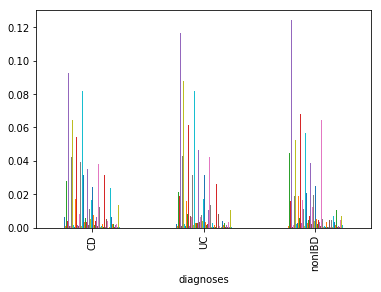

In [17]:
fig = differential.plot(x='diagnoses', kind='bar', legend=False)

# Transpose and plot

Since we want to compare with a single species, we transpose the data and plot organized by species. We also label the columns appropriately.

In [18]:
tdf = differential.transpose()[1:]
tdf = tdf.rename(columns={0:'CD', 1:'UC', 2:'nonIBD'})

# Plot the data

Here we make a larger plot (using figsize - the numbers are in inches not pixels), and manipulate the plot a little to make it look good.

This plot shows the abundance of different species in CD, UC, or controls. Almost ready to be published!

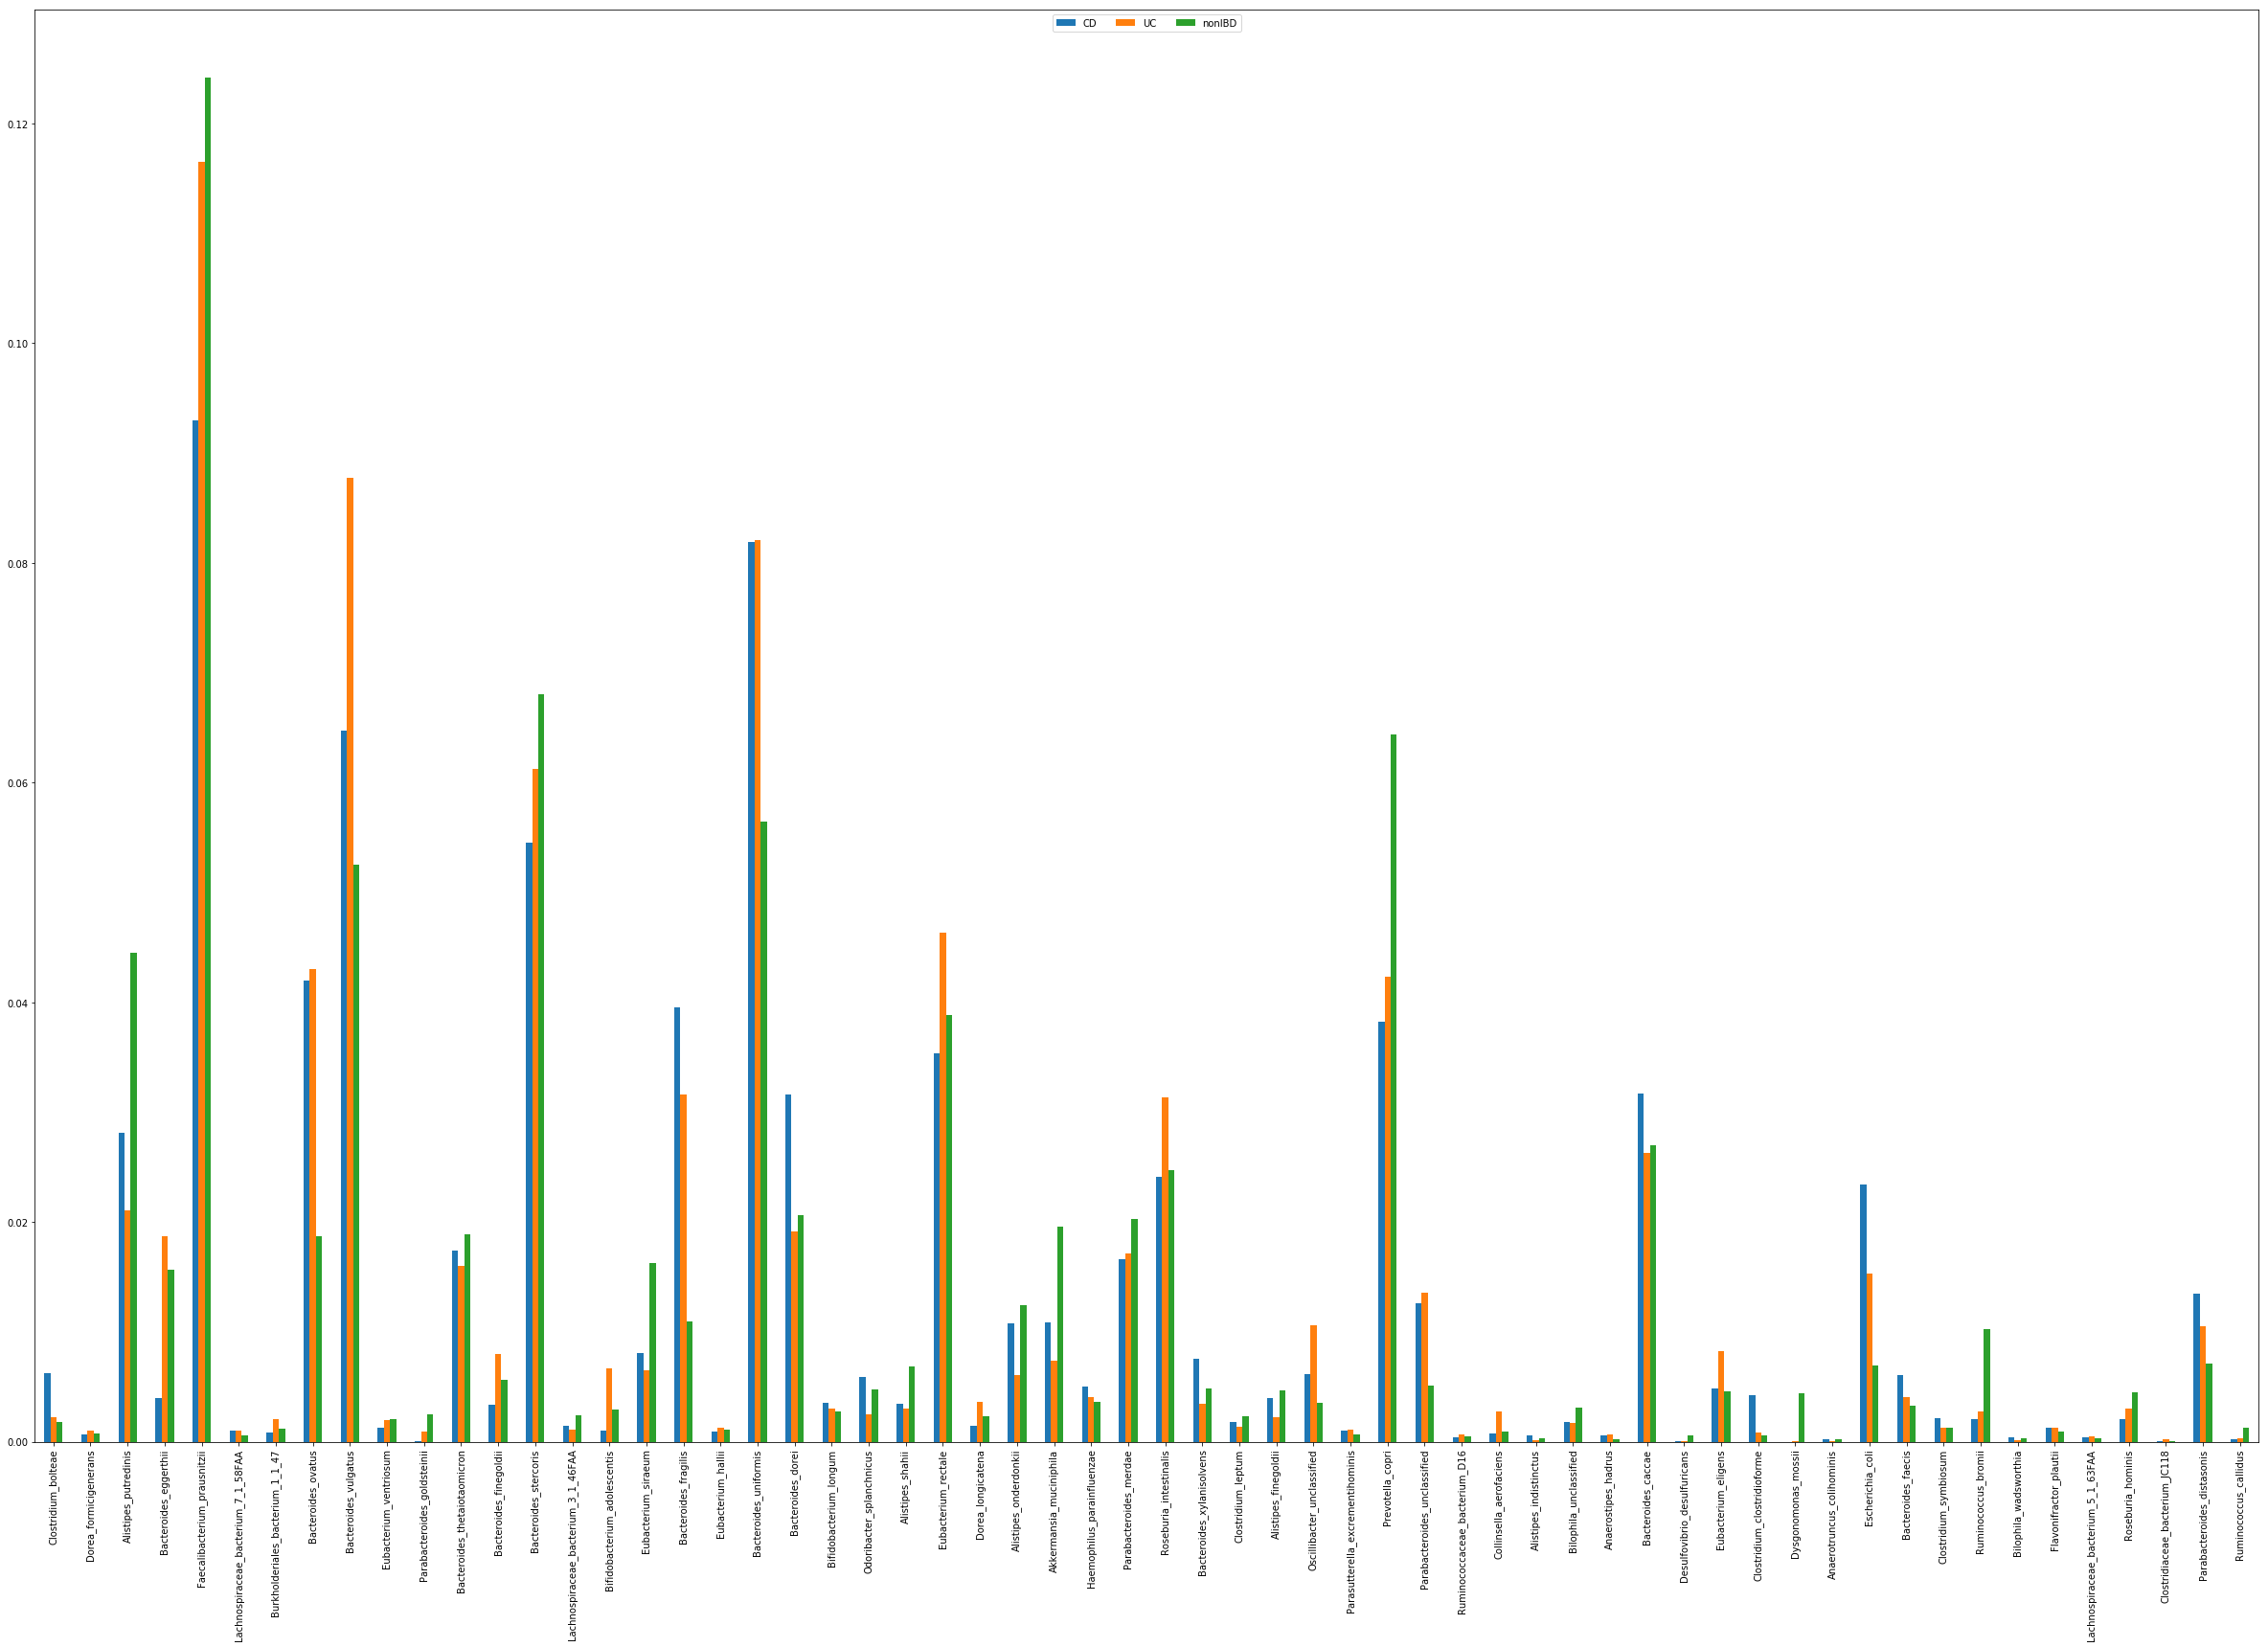

In [19]:
tplot=tdf.plot(kind='bar',figsize=(33, 24))
tplot.legend(loc='upper center', ncol=3)
tfig = tplot.get_figure()
tfig.tight_layout()
tfig.savefig('ibduc.png')